# Boilerplate

In [1]:
%load_ext autoreload
%autoreload

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import json
import optuna
import plotly
import yaml

from IPython.display import display
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def f():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
def nf():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 4)
nf()
import warnings
warnings.filterwarnings('ignore')

def dp(df, r = 5, c = None):
    from IPython.display import display
    with pd.option_context('display.max_rows', 4, 'display.max_columns', None):
        display(df)

def fg(w = 6, h = 4, dpi = 120):
    plt.rcParams['figure.figsize'] = (w,h)
    plt.rcParams['figure.dpi'] = dpi
fg()

/Users/vpb/opt/anaconda3/envs/lgbmenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [171]:
from libs.pipeline import Pipe
import lightgbm as lgb
from warnings import simplefilter
import shap

In [172]:
df = pd.read_csv("data/UCI_Credit_Card.csv")

df.columns = df.columns.str.lower()

df = df.drop('id', axis = 1)

df = df.rename(columns = {'default.payment.next.month':'target'})

df.to_parquet('data/df_to_feature_selection.parquet', index = False)

# Optuna

In [4]:
# split    
from sklearn.model_selection import train_test_split
def split(df, target_var:str, test_size:float=0.3):

    X = df.drop(target_var, axis = 1)
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = test_size,
                                                        random_state = 42)
    return X_train, X_test, y_train, y_test

In [5]:
from libs.tuning import Tuning

optuna.logging.set_verbosity(optuna.logging.WARNING)
simplefilter("ignore", category=RuntimeWarning)

In [6]:
target_var = 'target'
n_trials = 100
chosen_optimization = 'f1_score'
tuning = Tuning(df,
                target_var = target_var, 
                n_trials = n_trials,
                chosen_optimization=chosen_optimization)

[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will

[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bag

In [7]:
bestparams = tuning.study.best_params
with open('config/modelparams/params_v2.yml', 'w') as f:
    yaml.dump(bestparams, f)
bestparams

{'boosting': 'dart',
 'drop_rate': 0.375,
 'extra_trees': False,
 'device_type': 'cpu',
 'colsample_bytree': 1.0,
 'n_estimators': 110,
 'learning_rate': 0.2,
 'num_leaves': 20,
 'max_depth': 7,
 'min_gain_to_split': 0.09899999999999999,
 'min_data_in_leaf': 90,
 'min_child_weight': 0.00071,
 'lambda_l1': 0,
 'lambda_l2': 100,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.5,
 'feature_fraction_bynode': 0.4,
 'pos_bagging_fraction': 0.6000000000000001}

In [17]:
best = lgb.LGBMClassifier(objective = 'binary').set_params(**bestparams)

mbest = Pipe(df, target_var = 'target', model = best)

mbest.popin.scores

mbest.oos.scores

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=0.09899999999999999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09899999999999999
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


,accuracy,precision,recall,f1,auc,gini
0,0.81,0.58,0.53,0.55,0.8,0.6


,accuracy,precision,recall,f1,auc,gini
0,0.81,0.58,0.52,0.55,0.78,0.56


In [18]:
X_train = mbest.X_train
y_train = mbest.y_train
X_test = mbest.X_test
y_test = mbest.y_test

# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

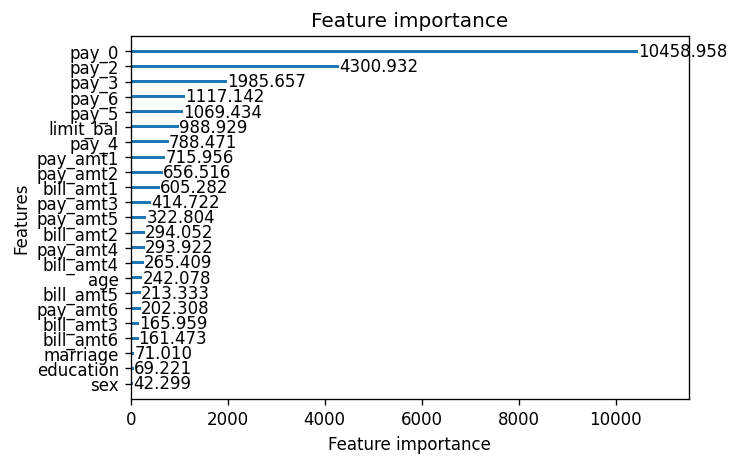

In [19]:
lgb.plot_importance(best, 
                    importance_type = 'gain', 
                    grid = False)

# Shap

In [173]:
explainer = shap.Explainer(best)
shap_values = explainer(X_test)

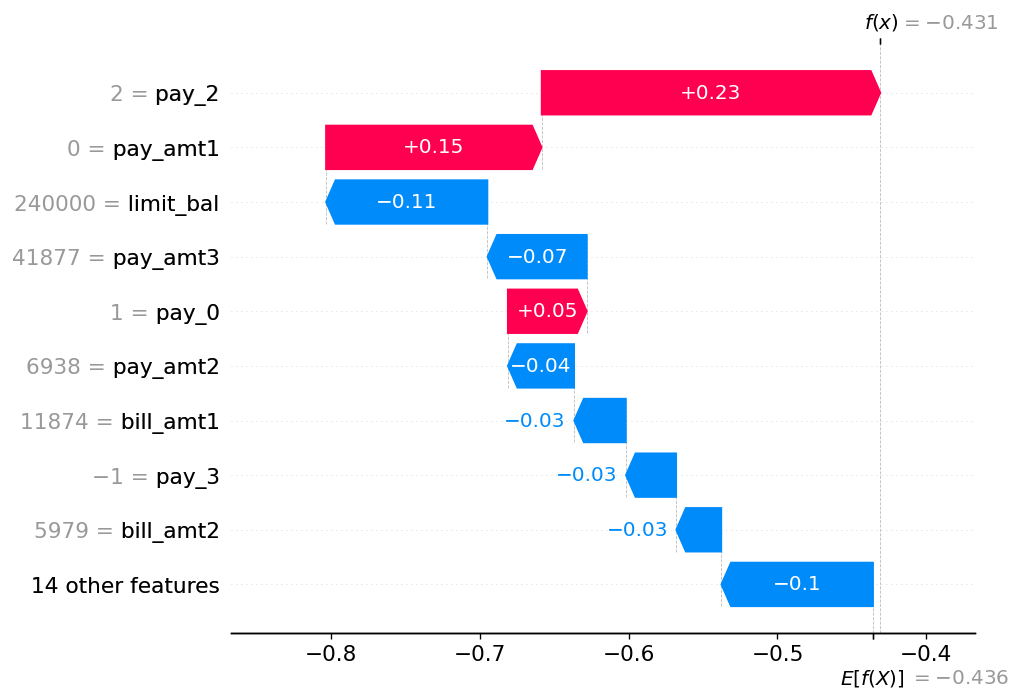

In [174]:
lgbm_shap_values = shap_values[:,:,1]
shap.plots.waterfall(lgbm_shap_values[4])

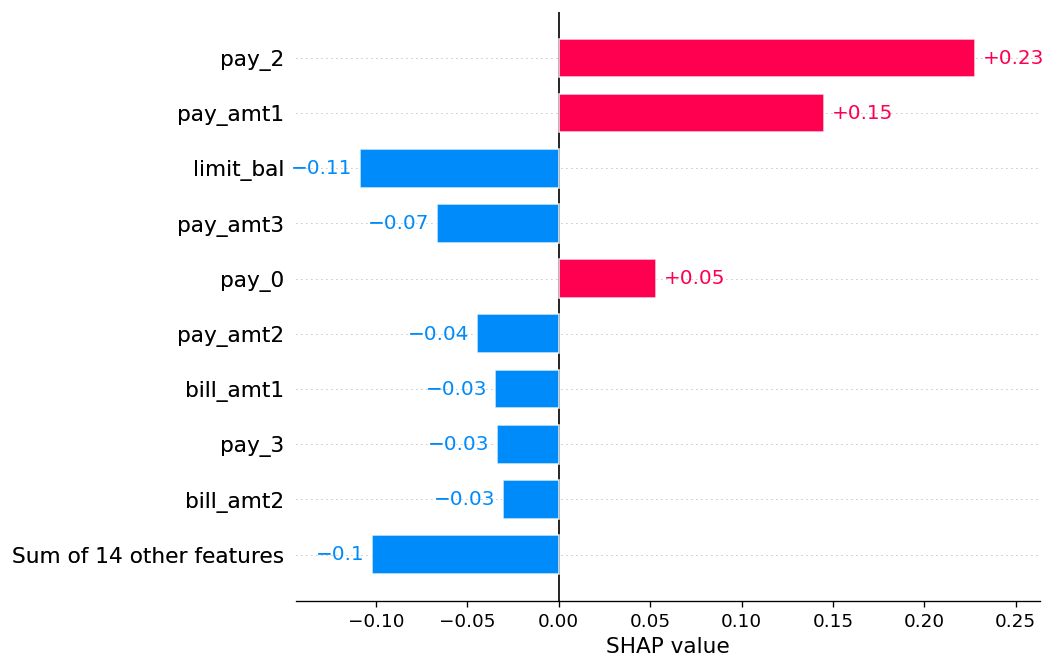

In [175]:
shap.plots.bar(lgbm_shap_values[4])

In [176]:
lgbm_expected_value = explainer.expected_value[0]

In [177]:
X = X_train.append(X_test)

In [ ]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [185]:
shap.dependence_plot(ind = 'pay_0', 
                     shap_values = lgbm_shap_values[:,0], 
                     features = X_test.values, 
                     feature_names=X_test.columns)

TypeError: order must be str, not int